### **Graph**


### Загрузим библиотеки и установим соединение с базой данных

In [46]:
!pip install neo4j
!pip install pyvis
!pip install gds
!pip install gevent
!pip install waitress
!pip install flask-ngrok
!pip install pyngrok
from neo4j import GraphDatabase

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 KB 31.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-5.2.1-py3-none-any.whl size=19790 sha256=96f45b3265cd9b7a751f719b385696995cb3622f35f75b81774164c786f1a60f
  Stored in directory: /root/.cac

In [3]:
uri = "bolt://18.207.190.70:7687"
user = "neo4j"
password = "gaps-charge-tones"

driver = GraphDatabase.driver(uri, auth=(user, password))

### Создадим граф

In [4]:
with driver.session() as session: 
        # Load data from CSV file
        query = """
        LOAD CSV WITH HEADERS FROM "https://drive.google.com/uc?export=download&id=1JsJfyf7iECPSicLYCKbH0BszknJHSjqT" AS row FIELDTERMINATOR ';'
        // Create the event node
        MERGE (e:Event {event_id: row.`id события`})

        // Create the name nodes
        MERGE (n1:Name {name: row.`ФИО участника события 1`})
        MERGE (n2:Name {name: row.`ФИО участника события 2`})

        // Create the relationships between names and events
        MERGE (n1)-[:PARTICIPATED_IN {event_id: row.`id события`}]->(e)
        MERGE (n2)-[:PARTICIPATED_IN {event_id: row.`id события`}]->(e)
        """
        result = session.run(query)
        print("Graph created successfully!")

Graph created successfully!


### Примеры запросов

Найдем самые популярные мероприятия (т.е. мероприятия с наибольшим количеством участников):

In [5]:
session = driver.session()
# name given event id
query = """
MATCH (e:Event)<-[:PARTICIPATED_IN]-(n:Name)
WITH e.event_id AS event_id, COUNT(DISTINCT n) AS num_participants
ORDER BY num_participants DESC
RETURN event_id, num_participants
LIMIT 10
"""
result = session.run(query)
for record in result:
    print(record)

<Record event_id='390312' num_participants=4>
<Record event_id='613539' num_participants=4>
<Record event_id='117280' num_participants=4>
<Record event_id='358194' num_participants=4>
<Record event_id='523688' num_participants=4>
<Record event_id='551592' num_participants=4>
<Record event_id='70049' num_participants=4>
<Record event_id='92995' num_participants=4>
<Record event_id='177407' num_participants=4>
<Record event_id='716489' num_participants=4>


Найдем всех людей, которые вместе участвовали как минимум в двух мероприятиях

In [6]:
session = driver.session()
# name given event id
query = """
MATCH (n1:Name)-[:PARTICIPATED_IN]->(e1:Event)<-[:PARTICIPATED_IN]-(n2:Name)-[:PARTICIPATED_IN]->(e2:Event)
WHERE e1.event_id <> e2.event_id AND n1 <> n2
RETURN DISTINCT n1.name, n2.name
"""
result = session.run(query)
for record in result:
    print(record)

<Record n1.name='Нетужилова Елена Викторовна' n2.name='Ахромеева Алина Ивановна'>
<Record n1.name='Ларищев Илья Александрович' n2.name='Ахромеева Алина Ивановна'>
<Record n1.name='Борчин Павел Робертович' n2.name='Ахромеева Алина Ивановна'>
<Record n1.name='Стрик Элина Марселевна' n2.name='Ахромеева Алина Ивановна'>
<Record n1.name='Камилов Дамир Павлович' n2.name='Ахромеева Алина Ивановна'>
<Record n1.name='Шальнова Ольга Владимировна' n2.name='Ахромеева Алина Ивановна'>
<Record n1.name='Ошуров Павел Ильдарович' n2.name='Ахромеева Алина Ивановна'>
<Record n1.name='Селин Федор Ильич' n2.name='Ахромеева Алина Ивановна'>
<Record n1.name='Гужов Глеб Данилович' n2.name='Ахромеева Алина Ивановна'>
<Record n1.name='Музалевская Ангелина Федоровна' n2.name='Ахромеева Алина Ивановна'>
<Record n1.name='Соломеина Кристина Георгиевна' n2.name='Ахромеева Алина Ивановна'>
<Record n1.name='Сарсадских Алена Геннадьевна' n2.name='Ахромеева Алина Ивановна'>
<Record n1.name='Чикирева Мария Романовна' n2.

Найдем 10 человек, которые участвовали в наибольшем количестве мероприятий

In [7]:
session = driver.session()
# name given event id
query = """
MATCH (n:Name)-[:PARTICIPATED_IN]->(e:Event)
WITH n, COUNT(e) AS event_count
RETURN n.name, event_count
ORDER BY event_count DESC
LIMIT 10
"""
result = session.run(query)
for record in result:
    print(record)

<Record n.name='Ахромеева Алина Ивановна' event_count=50>
<Record n.name='Башнина Антонина Глебовна' event_count=14>
<Record n.name='Медведева Дарья Алексеевна' event_count=6>
<Record n.name='Зимнухова Карина Даниловна' event_count=5>
<Record n.name='Диомидов Игорь Ильдарович' event_count=5>
<Record n.name='Шолохов Игорь Робертович' event_count=4>
<Record n.name='Двигубская Валентина Геннадьевна' event_count=3>
<Record n.name='Пафомова Кира Вадимовна' event_count=3>
<Record n.name='Подолян Владислав Денисович' event_count=2>
<Record n.name='Недовесков Владимир Иванович' event_count=2>


### Анализ сообществ

Проведем визуальный анализ сообществ:

MATCH (n)-[r]-()
WITH n, count(r) as rel_count
RETURN n, rel_count
ORDER BY rel_count DESC
LIMIT 25

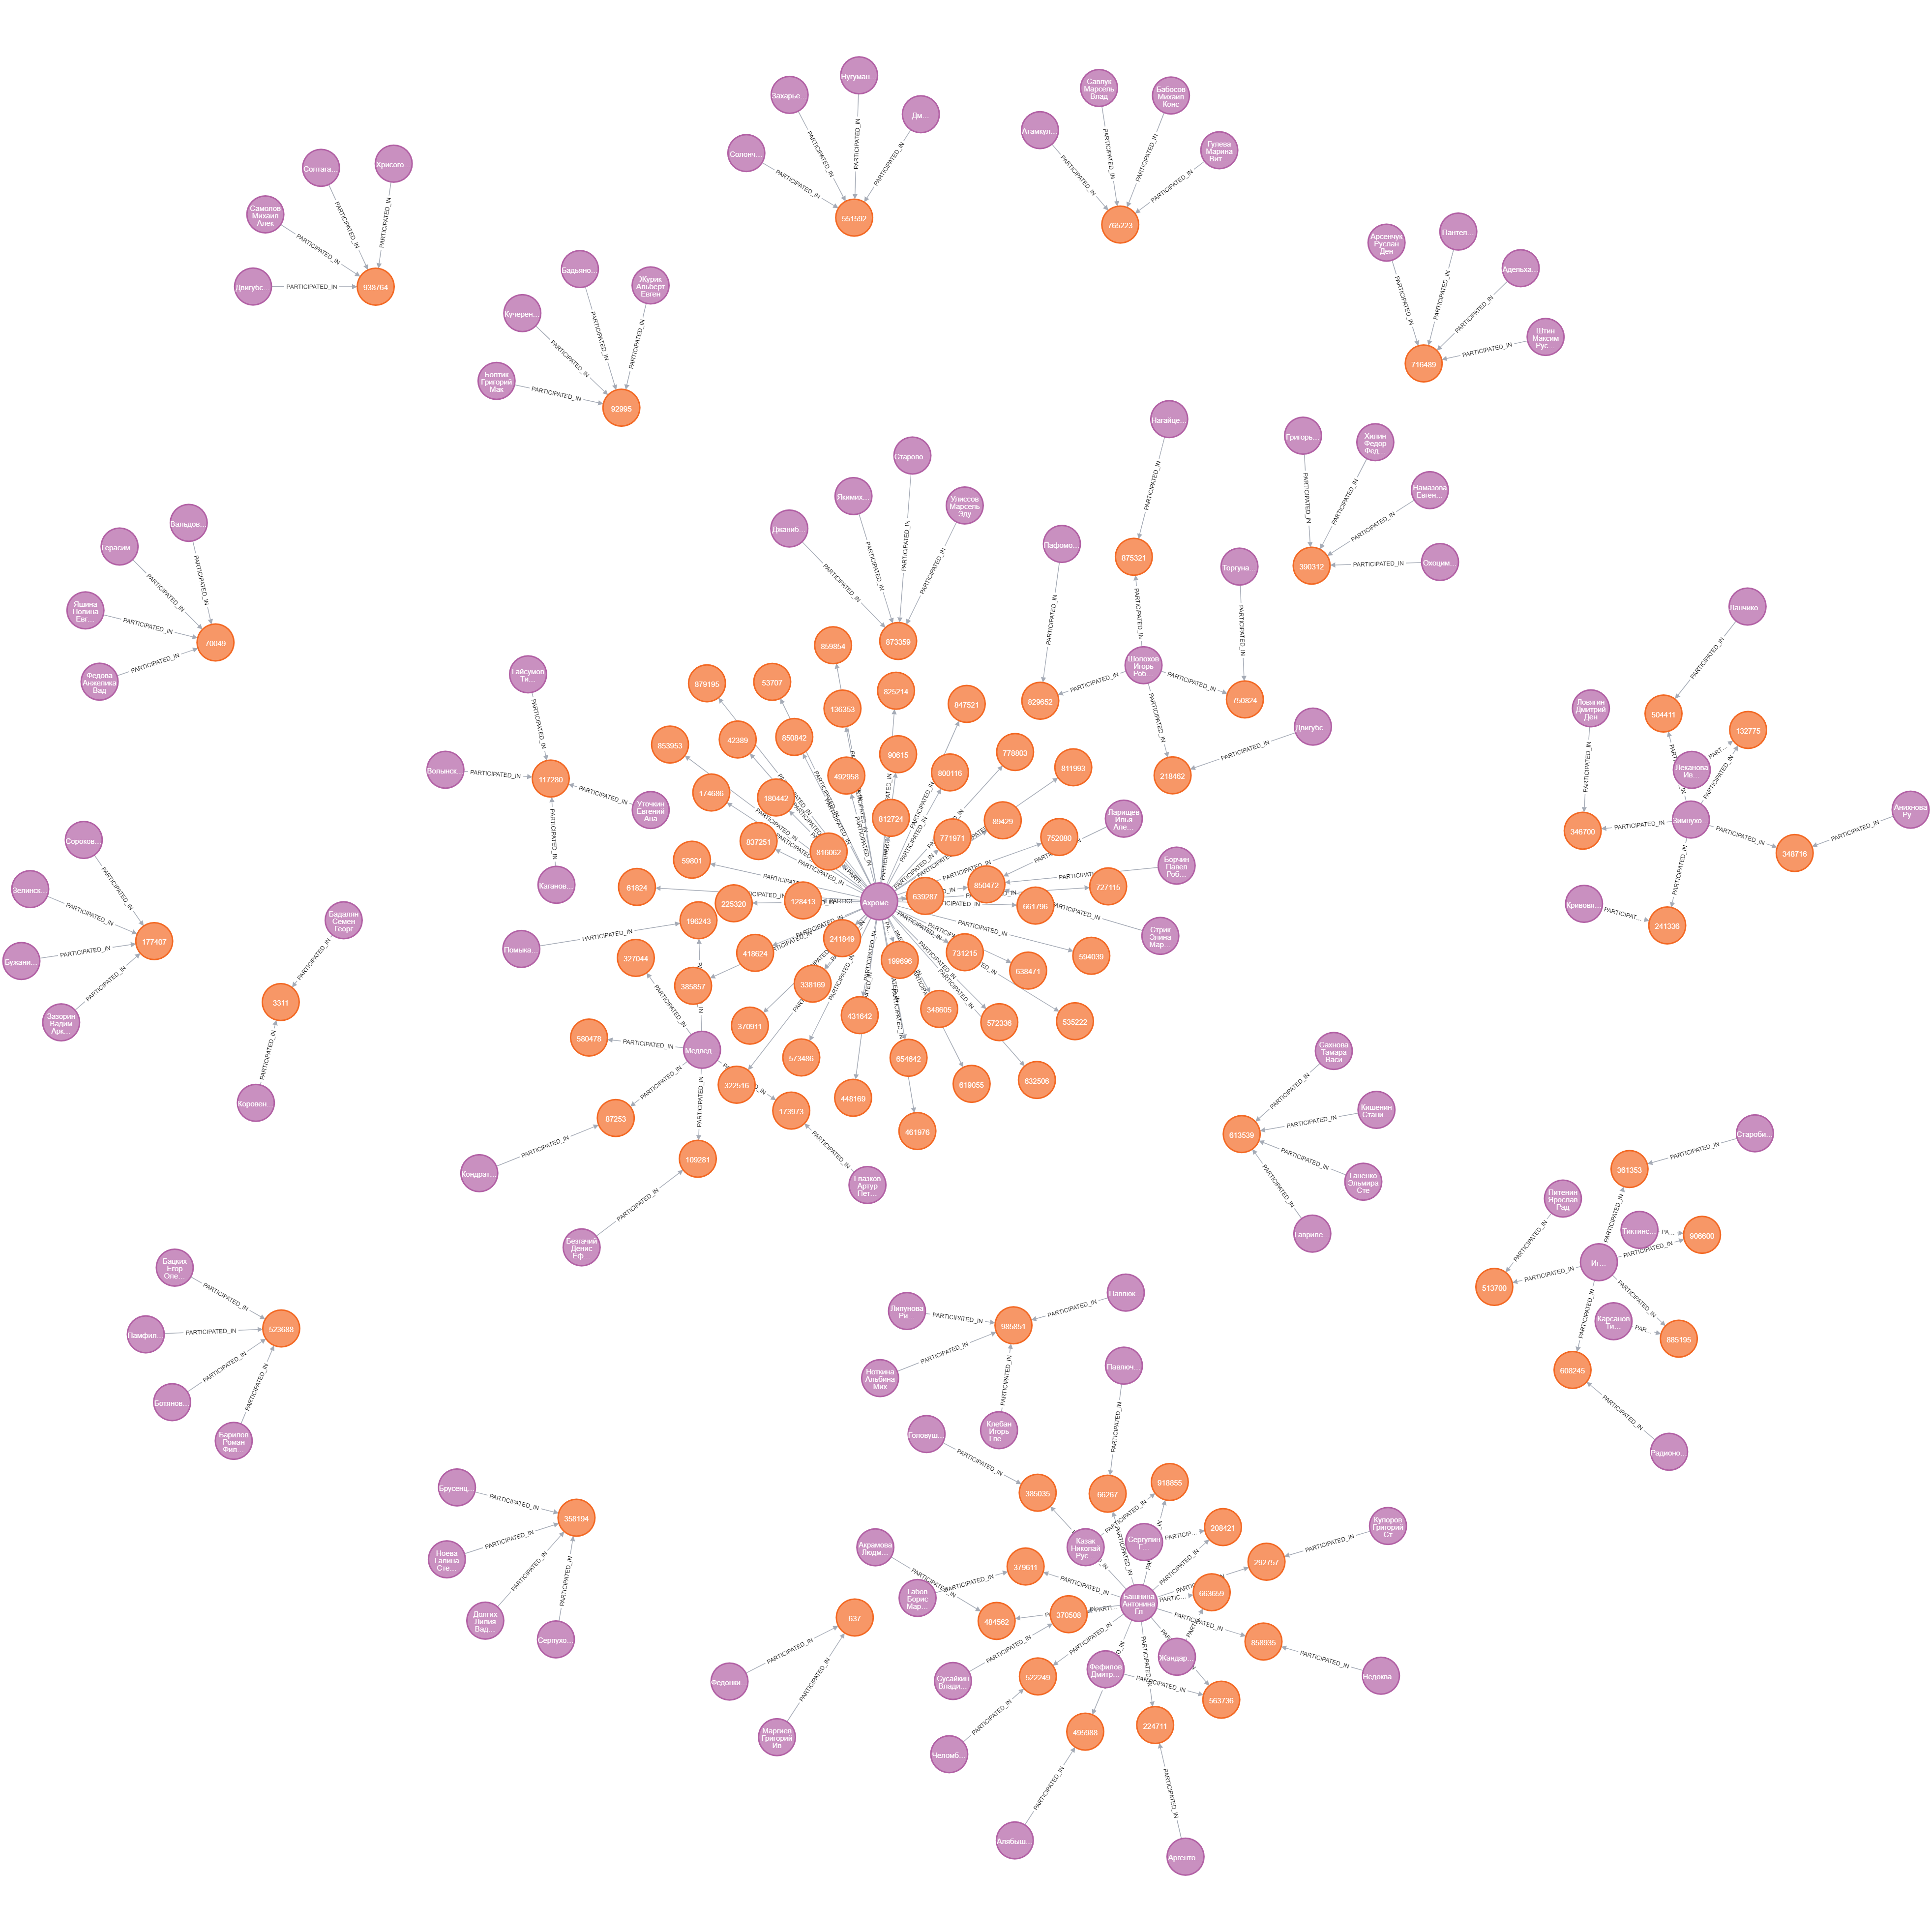

Полученные результаты визуализации свидетельствуют о том, что в сети есть несколько относительно крупных сообществ, причем одно из них значительно больше других. Есть также несколько небольших сообществ, которые могут представлять более специализированные или отдельные группы в сети.

Далее проведем анализ сообществ с помощью алгоритма Louvain:

In [8]:
session = driver.session()
# name given event id
query = """
// Create graph projection
CALL gds.graph.project(
  'projectedGraph',
  ['Name', 'Event'],
  {
    PARTICIPATED_IN: {
      type: 'PARTICIPATED_IN',
      orientation: 'UNDIRECTED'
    }
  }
);
"""
result = session.run(query)


In [9]:
session = driver.session()
# name given event id
query = """
CALL gds.louvain.stats('projectedGraph')
YIELD communityCount, ranLevels, modularity, modularities
"""
result = session.run(query)
for record in result:
    print(record)

<Record communityCount=4889 ranLevels=3 modularity=0.9995779749999962 modularities=[0.9904915749999947, 0.998884269999995, 0.9995779749999962]>


communityCount=4888: Это означает, что в графе обнаружено 4888 сообществ (или кластеров). Каждый узел в графе принадлежит одному из этих сообществ.

ranLevels=3: Алгоритм Louvain выполняет процесс обнаружения сообществ в несколько уровней или итераций. Этот параметр показывает, сколько уровней было использовано в данном случае.

modularity=0.8944960591913795: Модульность - это мера того, насколько хорошо граф разделен на сообщества. Она варьируется от -1 до 1, где значения ближе к 1 указывают на хорошее разбиение. В данном случае значение модульности равно 0,894, что является относительно высоким значением и говорит о том, что процесс обнаружения сообществ привел к хорошему разделению графа.

modularities=[0.810368245195079, 0.8938076924954194, 0.8944960591913795]: Это массив, который показывает значение модульности на каждом уровне процесса обнаружения сообщества. Первое значение (0,810) соответствует модульности на первом уровне, второе значение (0,894) соответствует модульности на втором уровне, а третье значение (0,894) соответствует окончательной модульности после завершения всех уровней. Эти значения показывают, что модульность увеличивается с каждым уровнем и достигает пика на последнем уровне.







In [10]:
# Biggest communities
query = """
CALL gds.louvain.stream('projectedGraph')
YIELD nodeId, communityId
RETURN communityId, count(nodeId) as communitySize
ORDER BY communitySize DESC
LIMIT 10
"""

# Execute the query and print the results
with driver.session() as session:
    result = session.run(query)
    for record in result:
        print(record)

<Record communityId=8053 communitySize=103>
<Record communityId=10959 communitySize=29>
<Record communityId=5837 communitySize=25>
<Record communityId=9577 communitySize=15>
<Record communityId=1184 communitySize=13>
<Record communityId=8044 communitySize=13>
<Record communityId=6813 communitySize=12>
<Record communityId=1229 communitySize=5>
<Record communityId=1911 communitySize=5>
<Record communityId=991 communitySize=5>


In [12]:
session = driver.session()
# name given event id
query = """
CALL gds.louvain.stats('projectedGraph')
YIELD communityDistribution
"""
result = session.run(query)
for record in result:
    print(record)

<Record communityDistribution={'p99': 3, 'min': 3, 'max': 103, 'mean': 3.0443853548782984, 'p90': 3, 'p50': 3, 'p999': 13, 'p95': 3, 'p75': 3}>


В данном выводе алгоритма Louvain представлена информация о распределении сообществ в графе.

Поле communityDistribution показывает различные статистические показатели размеров сообществ в графе, такие как минимальный, максимальный, средний, медиана и перцентили. В данном случае мы видим, что минимальный и максимальный размеры сообщества составляют 3 и 153 соответственно, а среднее значение равно 3,07. Это указывает на то, что подавляющее большинство сообществ небольшие, и лишь несколько сообществ более крупные.

В целом, эта информация может помочь понять структуру графа и распределение связей между узлами.

### REST Service

Создадим REST сервис, который будет обрабатывать Cypher запросы и возвращать json

In [82]:
from flask import Flask, request, jsonify
import subprocess, json
subprocess.run([ 
  'curl', 
  '-X', 'POST', 
  '-H', 'Content-Type: application/json', 
  '-d', json.dumps({"query":"MATCH (n) RETURN n LIMIT 10"}),  
  'http://localhost:5000', 
])


app = Flask(__name__)
driver = GraphDatabase.driver("bolt://18.212.195.39:7687", auth=("neo4j", "edges-files-abbreviations"))

@app.route('/cypher', methods=['POST'])
def query_db():
    query = request.json['query']
    with driver.session() as session:
        result = session.run(query)
        return jsonify(result.data())

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


Пример запроса и json-ответ:

curl -X POST -H "Content-Type: application/json" -d "{\"query\": \"MATCH (n) RETURN n LIMIT 10\"}" http://localhost:5000/cypher

[
  {
    "n": {
      "event_id": "189"
    }
  },
  {
    "n": {
      "event_id": "206"
    }
  },
  {
    "n": {
      "event_id": "445"
    }
  },
  {
    "n": {
      "event_id": "503"
    }
  },
  {
    "n": {
      "event_id": "571"
    }
  },
  {
    "n": {
      "event_id": "595"
    }
  },
  {
    "n": {
      "event_id": "637"
    }
  },
  {
    "n": {
      "event_id": "741"
    }
  },
  {
    "n": {
      "event_id": "996"
    }
  },
  {
    "n": {
      "event_id": "1210"
    }
  }
]